In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os

from tqdm.notebook import tqdm

In [2]:
data_fold = "../../../data/carla_sim/random_spawn"
exp_fold = "../../../data/experiments/carla_sim/random_spawn"

In [433]:
WIDTH, HEIGHT = 640, 480

N_SUBDIV_X = 2
N_SUBDIV_Y = 2
SUBDIV_WIDTH, SUBDIV_HEIGHT = WIDTH // N_SUBDIV_X, HEIGHT // N_SUBDIV_Y
N_DISCARD_TOP = 1
N_DISCARD_BOTTOM = 1
N_DISCARD_LEFT = 1
N_DISCARD_RIGHT = 1

T_STEPS = 180

T_STEPS_T_COLL_MAX = 100  # number of time steps before collision to consider as a positive output if a collision occurs in the sequence

In [511]:
class SigmoidScaleBias(nn.Module):
    def __init__(self, dim, scale=True, bias=True, single_param=False):
        super().__init__()
        if bias:
            self.bias = nn.Parameter(torch.Tensor(1 if single_param else dim))
        else:
            # You should always register all possible parameters, but the
            # optional ones can be None if you want.
            self.register_parameter('bias', None)
        if scale:
            self.scale = nn.Parameter(torch.Tensor(1 if single_param else dim))
        else:
            self.register_parameter('scale', None)
        
        if self.bias is not None:
            self.bias.data.uniform_(0, 0)

        if self.scale is not None:
            self.scale.data.uniform_(1, 1)

    def forward(self, input):
        output = input
        if self.scale is not None:
            output *= self.scale.unsqueeze(0).expand_as(output)
        if self.bias is not None:
            output -= self.bias.unsqueeze(0).expand_as(output)
        return torch.sigmoid(output)

In [548]:
class Net(nn.Module):
    def __init__(
        self,
        width=SUBDIV_WIDTH,
        height=SUBDIV_HEIGHT,
        kern_half_size=3,
        rmo_head=True,
        sigm_kern=0.3,
        reg=1.5,
        dt=10.0,
        r_out_sigm_scale=500.0,
        r_out_scale=500.0,
        train_weights=True,
        size_layers=[10],
        use_dropout=False,
        train_kernels=False,
    ):
        super().__init__()

        self.width = width
        self.height = height
        self.kern_half_size = kern_half_size
        self.size_layers = (
            size_layers if isinstance(size_layers, list) else [size_layers]
        )
        self.kern_size = 2 * kern_half_size + 1

        self.sigm_kern = sigm_kern

        #self.reg = nn.Parameter(torch.tensor([reg]).float())
        self.reg = reg

        #self.r_out_sigm_scale = nn.Parameter(torch.tensor([r_out_sigm_scale]).float())

        self.dt = dt

        self.train_weights = train_weights

        self.rmo_head = rmo_head
        self.use_dropout = use_dropout

        _x, _y = np.meshgrid(
            np.arange(-kern_half_size, kern_half_size + 1),
            np.arange(-kern_half_size, kern_half_size + 1),
        )

        self.kern_x = nn.Conv2d(
            1, 1, self.kern_size, padding=kern_half_size, bias=False
        )

        self.kern_y = nn.Conv2d(
            1, 1, self.kern_size, padding=kern_half_size, bias=False
        )

        self.kern_norm = nn.Conv2d(
            1, 1, self.kern_size, padding=kern_half_size, bias=False
        )

        _gauss = np.exp(-(_x**2 + _y**2) / (2.0 * (sigm_kern * kern_half_size) ** 2))
        _gauss /= _gauss.sum()

        with torch.no_grad():

            self.kern_norm.weight.data = nn.Parameter(
                torch.tensor(_gauss).float().unsqueeze(0).unsqueeze(0),
            )
            self.kern_norm.weight.requires_grad = train_kernels

            self.kern_x.weight.data = nn.Parameter(
                torch.tensor(_x * _gauss).float().unsqueeze(0).unsqueeze(0),
            )
            self.kern_x.weight.requires_grad = train_kernels

            self.kern_y.weight.data = nn.Parameter(
                torch.tensor(_y * _gauss).float().unsqueeze(0).unsqueeze(0),
            )
            self.kern_y.weight.requires_grad = train_kernels

        self.vx = torch.zeros((1, 1, height, width)).float()
        self.vy = torch.zeros((1, 1, height, width)).float()

        _x, _y = np.meshgrid(
            np.linspace(-1, 1, width),
            np.linspace(-height / width, height / width, height),
        )

        with torch.no_grad():
            self.wx = nn.Parameter(torch.tensor(_x).float().unsqueeze(0).unsqueeze(0))
            self.wx.requires_grad = self.train_weights
            self.wy = nn.Parameter(torch.tensor(_y).float().unsqueeze(0).unsqueeze(0))
            self.wy.requires_grad = self.train_weights

            #self.wx = nn.Parameter(torch.zeros((1, 1, height, width)))
            #self.wy = nn.Parameter(torch.zeros((1, 1, height, width)))

        """
        self.layers = []

        self.layers.append(nn.Flatten())

        if len(size_layers) > 0:
            for i in range(len(size_layers)):
                if i == 0:
                    self.layers.append(nn.Linear(width * height, size_layers[i]))
                else:
                    self.layers.append(nn.Linear(size_layers[i - 1], size_layers[i]))
                self.layers.append(nn.ReLU())
            self.layers.append(nn.Linear(size_layers[-1], 1))
        else:
            self.layers.append(nn.Linear(width * height, 1))

        self.layers = nn.Sequential(*self.layers)
        """
        self.fwd = nn.Sequential(
            nn.Flatten(),
            nn.Linear(width * height, 2, bias=False),
        )

        w_pos = np.exp(-_x**2. / (2. * 0.25 ** 2)) * np.exp(-_y**2. / (2. * 0.25 ** 2))
        w_pos_left = np.zeros_like(w_pos)
        w_pos_left[:, :width // 2] = w_pos[:, :width // 2]
        #w_pos_left /= w_pos_left.sum()
        w_pos_right = np.zeros_like(w_pos)
        w_pos_right[:, width // 2:] = w_pos[:, width // 2:]
        #w_pos_right /= w_pos_right.sum()

        with torch.no_grad():
            self.fwd[1].weight.data[0] = nn.Parameter(torch.tensor(w_pos_left.flatten()).float())
            self.fwd[1].weight.data[1] = nn.Parameter(torch.tensor(w_pos_right.flatten()).float())
            self.fwd[1].weight.requires_grad = self.train_weights

        #with torch.no_grad():
        #    self.fwd[1].weight.data[0] = nn.Parameter(torch.tensor((_x < 0.0).flatten()).float())
        #    self.fwd[1].weight.data[1] = nn.Parameter(torch.tensor((_x > 0.0).flatten()).float())


        self.sigm = SigmoidScaleBias(2, single_param=True)

        with torch.no_grad():
            self.sigm.scale = nn.Parameter(torch.tensor([r_out_sigm_scale]).float())

        self.out_scale = nn.Parameter(torch.tensor([r_out_scale]).float())

        self.out_th = nn.Parameter(torch.zeros((1)).float())

        if self.use_dropout:
            self.dropout = nn.Dropout(self.use_dropout)

    def forward(self, x):
        x_p = (x > 0).float()
        x_n = (x < 0).float()

        if self.use_dropout:
            x_p = self.dropout(x_p)
            x_n = self.dropout(x_n)

        I_x_p_prev = self.kern_x(x_p[..., 0:1, :, :])
        I_y_p_prev = self.kern_y(x_p[..., 0:1, :, :])
        I_norm_p_prev = self.kern_norm(x_p[..., 0:1, :, :])

        vx_p = -x_p[..., 1:2, :, :] * I_x_p_prev * self.dt / (self.reg**2 + I_norm_p_prev * self.dt**2)
        vy_p = -x_p[..., 1:2, :, :] * I_y_p_prev * self.dt / (self.reg**2 + I_norm_p_prev * self.dt**2)

        I_x_n_prev = self.kern_x(x_n[..., 0:1, :, :])
        I_y_n_prev = self.kern_y(x_n[..., 0:1, :, :])
        I_norm_n_prev = self.kern_norm(x_n[..., 0:1, :, :])

        vx_n = -x_n[..., 1:2, :, :] * I_x_n_prev * self.dt / (self.reg**2 + I_norm_n_prev * self.dt**2)
        vy_n = -x_n[..., 1:2, :, :] * I_y_n_prev * self.dt / (self.reg**2 + I_norm_n_prev * self.dt**2)

        self.vx = vx_p + vx_n
        self.vy = vy_p + vy_n

        v_project = self.vx * self.wx + self.vy * self.wy

        #left_right = self.r_out_scale * self.fwd(v_project)
        left_right = self.fwd(v_project)

        if self.rmo_head:
            out = self.out_scale * torch.min(left_right, dim=1).values * torch.prod(self.sigm(left_right), dim=1) - self.out_th
        else:
            out = self.out_scale * left_right.mean(dim=1) - self.out_th
        #

        return out
        #return self.layers(v_project)

In [5]:
def load_raw_data(fold):
    samples = [f for f in os.listdir(fold) if f.startswith("example")]
    samples.sort(key=lambda x: int(x.split("_")[1]))

    labels = []
    metadata = []
    data = []

    mem_gb = 0

    for sample in samples:
        events = np.load(os.path.join(fold, sample, "events.npy"))
        metadat = np.load(os.path.join(fold, sample, "sim_data.npz"), allow_pickle=True)

        labels.append(int(metadat["coll_type"] != "none"))

        data.append(events)

        mem_gb += events.nbytes / 1e9
        print(f"Total estimate of event data size: {mem_gb:.2f} GB", end="\r")

        metadata.append(
            {
                "coll_type": metadat["coll_type"][()],
                "t_end_ms": metadat["t_end"][()],
                "dt": metadat["dt"][()],
                "vel": metadat["vel"][()],
                "diam": metadat["diameter_object"][()],
            }
        )
    
    return data, labels, metadata

In [8]:
raw_data, raw_labels, raw_metadata = load_raw_data(data_fold)

In [10]:
def convert_to_tens(data, labels, metadata, t_steps):
    X = []

    idx_drop = []
    for i, events in tqdm(enumerate(data)):
        dt = metadata[i]["dt"]
        t_end = metadata[i]["t_end_ms"]
        nt = int(t_end / dt)
        if nt < t_steps:
            idx_drop.append(i)
            print(f"Sample {i} has too few frames, dropping it.")
            continue
        _dat = torch.zeros(t_steps, SUBDIV_HEIGHT, SUBDIV_WIDTH).type(torch.int8)
        for t in tqdm(range(t_steps), leave=False):
            _evts = events[
                (events["t"] >= (t + nt - t_steps) * dt)
                & (events["t"] < (t + 1 + nt - t_steps) * dt)
                & (events["y"] >= N_DISCARD_TOP * SUBDIV_HEIGHT // 2)
                & (events["y"] < HEIGHT - N_DISCARD_BOTTOM * SUBDIV_HEIGHT // 2)
                & (events["x"] >= N_DISCARD_LEFT * SUBDIV_WIDTH // 2)
                & (events["x"] < WIDTH - N_DISCARD_RIGHT * SUBDIV_WIDTH // 2)
            ]
            _dat[
                t,
                _evts["y"] - N_DISCARD_TOP * SUBDIV_HEIGHT // 2,
                _evts["x"] - N_DISCARD_LEFT * SUBDIV_WIDTH // 2,
            ] = torch.tensor(2 * _evts["p"].astype(int) - 1).type(torch.int8)
        X.append(_dat)

    X = torch.stack(X)

    labels = torch.tensor([labels[i] for i in range(len(labels)) if i not in idx_drop]).type(torch.int8)
    metadata = [metadata[i] for i in range(len(metadata)) if i not in idx_drop]

    return X, labels, metadata
    

In [121]:
#X, Y, metadata = convert_to_tens(raw_data, raw_labels, raw_metadata, T_STEPS)

In [25]:
try:
    torch.save(X, "X.pt")
    torch.save(Y, "Y.pt")
    torch.save(metadata, "metadata.pt")
except:
    print("Could not save tensors.")

In [6]:
X = torch.load(os.path.join(exp_fold, "X.pt"))
Y = torch.load(os.path.join(exp_fold, "Y.pt"))
metadata = torch.load(os.path.join(exp_fold, "metadata.pt"))

/tmp/ipykernel_1207901/177227970.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load(os.path.join(exp_fold, "X.pt"))
/tmp/ipykernel_1207901/177227970.py:2: Fu

In [101]:
def gen_x_sequ(X, Y, t_steps_to_coll_max=None):
    _t_steps = X.shape[1]
    X_1 = X[:,1:,...]
    X_0 = X[:,:-1,...]
    X_seq = torch.stack([X_0, X_1], dim=2)
    X_seq = X_seq.view(-1, X_seq.shape[-3], X_seq.shape[-2], X_seq.shape[-1])
    
    Y_expand = Y.unsqueeze(1).repeat(1,_t_steps-1)#.flatten()
    if t_steps_to_coll_max is not None:
        Y_expand[:,:-t_steps_to_coll_max] = 0
    Y_expand = Y_expand.flatten()

    return X_seq, Y_expand

In [434]:
X_seq, Y_seq = gen_x_sequ(X, Y, T_STEPS_T_COLL_MAX)

In [10]:
try:
    torch.save(X_seq, "X_seq.pt")
    torch.save(Y_seq, "Y_seq.pt")
except:
    print("Could not save tensors.")

In [436]:
n_samples = X_seq.shape[0]

# split data into training, validation and test sets
n_train = int(0.7 * n_samples)
n_val = int(0.15 * n_samples)
n_test = n_samples - n_train

idx = torch.randperm(n_samples)

X_train = X_seq[idx[:n_train]]
X_val = X_seq[idx[n_train:n_train+n_val]]
X_test = X_seq[idx[n_train+n_val:]]

Y_train = Y_seq[idx[:n_train]]
Y_val = Y_seq[idx[n_train:n_train+n_val]]
Y_test = Y_seq[idx[n_train+n_val:]]

In [437]:
# create dataloaders

train_data = torch.utils.data.TensorDataset(X_train, Y_train)
val_data = torch.utils.data.TensorDataset(X_val, Y_val)
test_data = torch.utils.data.TensorDataset(X_test, Y_test)

BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [555]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = Net(
    kern_half_size=2,
    sigm_kern=0.3,
    reg=0.1,
    r_out_sigm_scale=1.0,
    r_out_scale=1.0,
    size_layers=[],
    rmo_head=True,
    use_dropout=0.02,
    train_kernels=False,
    train_weights=False,
)
net.to(device)

Net(
  (kern_x): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (kern_y): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (kern_norm): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (fwd): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=76800, out_features=2, bias=False)
  )
  (sigm): SigmoidScaleBias()
  (dropout): Dropout(p=0.02, inplace=False)
)

In [556]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

N_EPOCHS = 25

train_losses = []
val_losses = []

noise = 0.05

for epoch in range(N_EPOCHS):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = loss_fn(outputs.flatten(), labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    print(f"Epoch {epoch + 1}, loss: {running_loss / len(train_loader)}")

    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            val_loss += loss_fn(outputs.flatten(), labels.float()).item()
        
    val_losses.append(val_loss / len(val_loader))
    print(f"Validation loss: {val_loss / len(val_loader)}")

Epoch 1, loss: 0.5365312908098335
Validation loss: 0.4770137140663659
Epoch 2, loss: 0.44098828424802
Validation loss: 0.4164440186648834
Epoch 3, loss: 0.40031862551473196
Validation loss: 0.38958654607214577
Epoch 4, loss: 0.38256773034705543
Validation loss: 0.3784887915159144
Epoch 5, loss: 0.37527726249310983
Validation loss: 0.374325306586376
Epoch 6, loss: 0.37239414640746193
Validation loss: 0.37274932388852283
Epoch 7, loss: 0.3712321449441747
Validation loss: 0.37233846280269506
Epoch 8, loss: 0.3708189655563438
Validation loss: 0.3722725238015012
Epoch 9, loss: 0.37035944328414205
Validation loss: 0.372243472533982
Epoch 10, loss: 0.3701487192737807
Validation loss: 0.3722772759998717
Epoch 11, loss: 0.3701143225957274
Validation loss: 0.37233346755184776
Epoch 12, loss: 0.3703164474365755
Validation loss: 0.37242778381559904
Epoch 13, loss: 0.3702792643584038
Validation loss: 0.37248604104104566
Epoch 14, loss: 0.3702988346736312
Validation loss: 0.37259901723847155
Epoch 1

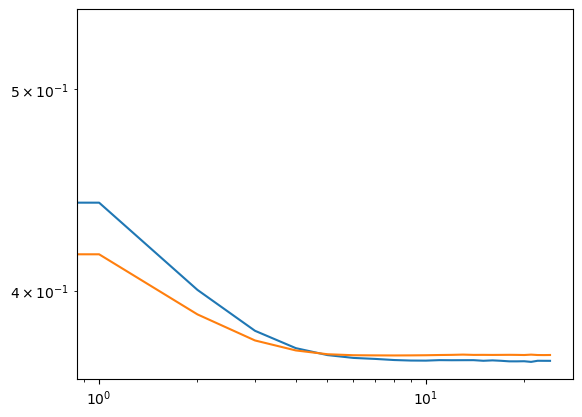

In [559]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.yscale("log")
plt.xscale("log")
plt.show()

In [560]:
# test the model

net.eval()

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)

        predicted = (outputs > 0).int()

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the test set: {100 * correct / total}%")

Accuracy of the network on the test set: 84.93412258926867%


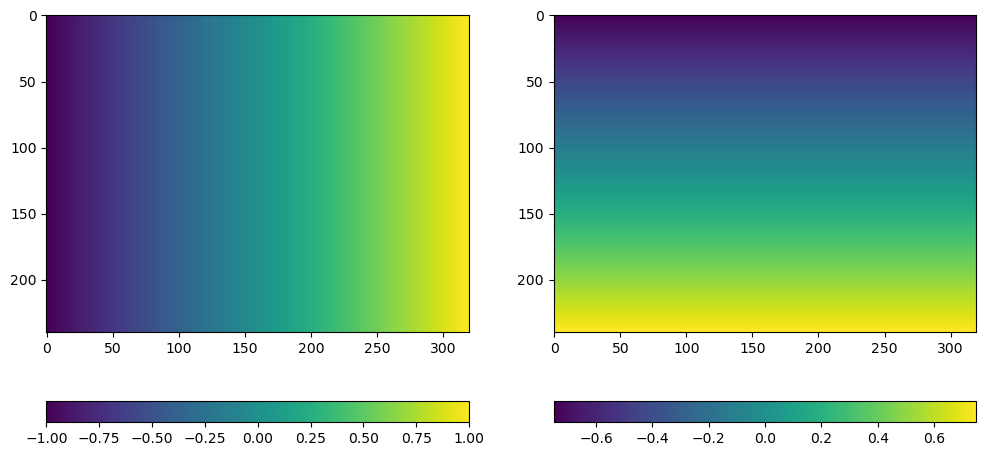

In [35]:
net.eval()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

img0 = ax[0].imshow(net.wx.detach().cpu().numpy().squeeze())
plt.colorbar(img0, ax=ax[0], orientation="horizontal")

img1 = ax[1].imshow(net.wy.detach().cpu().numpy().squeeze())
plt.colorbar(img1, ax=ax[1], orientation="horizontal")

plt.show()

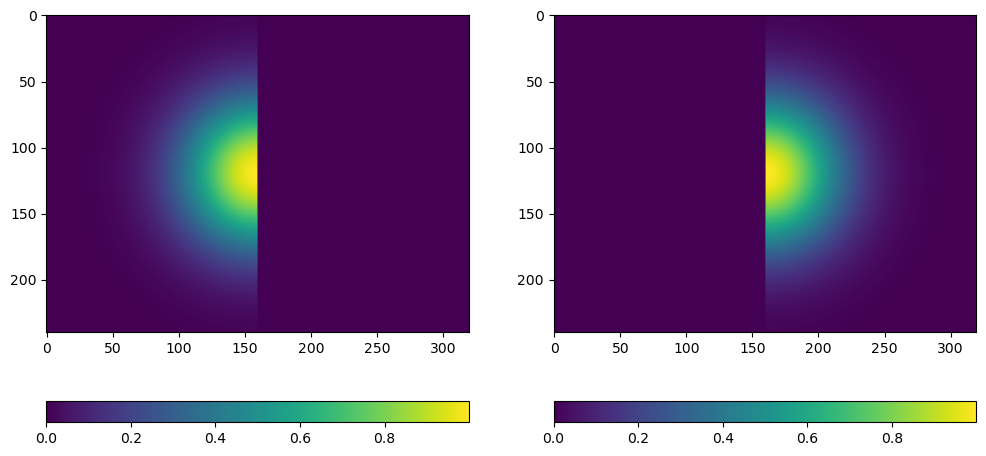

In [522]:
net.eval()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

img0 = ax[0].imshow(net.fwd[1].weight.detach().cpu().numpy()[0].reshape(SUBDIV_HEIGHT, SUBDIV_WIDTH))
plt.colorbar(img0, ax=ax[0], orientation="horizontal")

img1 = ax[1].imshow(net.fwd[1].weight.detach().cpu().numpy()[1].reshape(SUBDIV_HEIGHT, SUBDIV_WIDTH))
plt.colorbar(img1, ax=ax[1], orientation="horizontal")

plt.show()

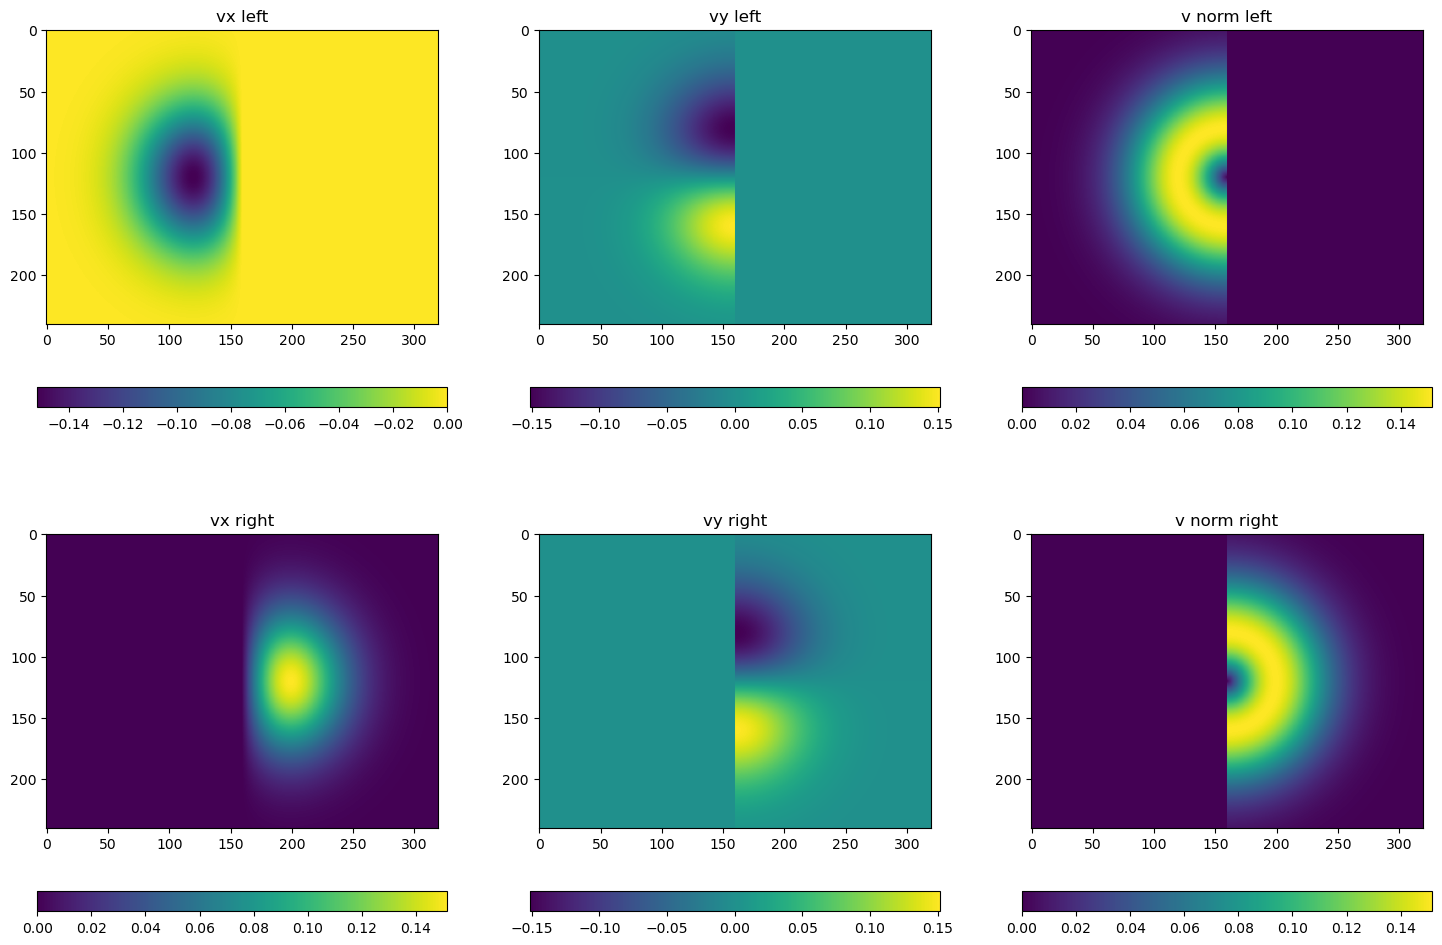

In [523]:
net.eval()

fig, ax = plt.subplots(2, 3, figsize=(18, 12))

ax = ax.flatten()

img0 = ax[0].imshow(net.wx.detach().cpu().numpy().squeeze() * net.fwd[1].weight.detach().cpu().numpy()[0].reshape(SUBDIV_HEIGHT, SUBDIV_WIDTH))
plt.colorbar(img0, ax=ax[0], orientation="horizontal")
ax[0].set_title("vx left")

img1 = ax[1].imshow(net.wy.detach().cpu().numpy().squeeze() * net.fwd[1].weight.detach().cpu().numpy()[0].reshape(SUBDIV_HEIGHT, SUBDIV_WIDTH))
plt.colorbar(img1, ax=ax[1], orientation="horizontal")
ax[1].set_title("vy left")

img_norm1 = ax[2].imshow(
    np.sqrt((net.wy.detach().cpu().numpy().squeeze() * net.fwd[1].weight.detach().cpu().numpy()[0].reshape(SUBDIV_HEIGHT, SUBDIV_WIDTH))**2 +
            (net.wx.detach().cpu().numpy().squeeze() * net.fwd[1].weight.detach().cpu().numpy()[0].reshape(SUBDIV_HEIGHT, SUBDIV_WIDTH))**2
            )
        )
plt.colorbar(img_norm1, ax=ax[2], orientation="horizontal")
ax[2].set_title("v norm left")


img2 = ax[3].imshow(net.wx.detach().cpu().numpy().squeeze() * net.fwd[1].weight.detach().cpu().numpy()[1].reshape(SUBDIV_HEIGHT, SUBDIV_WIDTH))
plt.colorbar(img2, ax=ax[3], orientation="horizontal")
ax[3].set_title("vx right")

img3 = ax[4].imshow(net.wy.detach().cpu().numpy().squeeze() * net.fwd[1].weight.detach().cpu().numpy()[1].reshape(SUBDIV_HEIGHT, SUBDIV_WIDTH))
plt.colorbar(img3, ax=ax[4], orientation="horizontal")
ax[4].set_title("vy right")

img_norm2 = ax[5].imshow(
    np.sqrt((net.wy.detach().cpu().numpy().squeeze() * net.fwd[1].weight.detach().cpu().numpy()[1].reshape(SUBDIV_HEIGHT, SUBDIV_WIDTH))**2 +
            (net.wx.detach().cpu().numpy().squeeze() * net.fwd[1].weight.detach().cpu().numpy()[1].reshape(SUBDIV_HEIGHT, SUBDIV_WIDTH))**2
            )
        )
plt.colorbar(img_norm1, ax=ax[5], orientation="horizontal")
ax[5].set_title("v norm right")

plt.show()

In [176]:
net.fwd[1].weight.data.shape

torch.Size([2, 76800])

In [ ]:
net.kern_norm.weight.requires_grad

False

71
1


/tmp/ipykernel_1207901/1633213011.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = _o


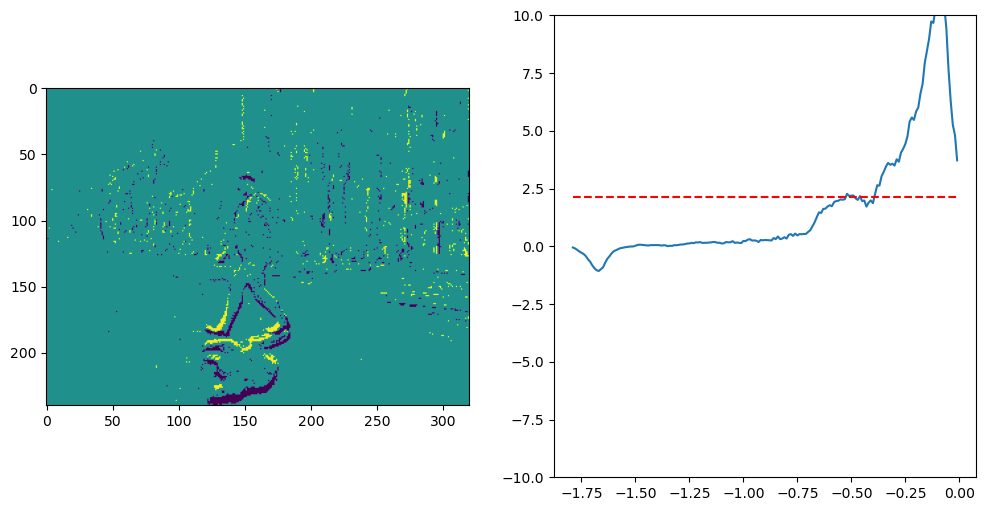

In [628]:
search_for = 1

while True:
    sample = np.random.randint(0, X.shape[0])
    if Y[sample] == search_for:
        break

print(sample)
print(Y[sample].detach().cpu().numpy())

steps = T_STEPS - 1

net.eval()
out = np.zeros((steps))
_o = 0.0
with torch.no_grad():
    for k in range(steps):
        img = torch.stack([X[sample,k,...], X[sample,k+1,...]], dim=0).float().to(device)
        #for i in range(_evts.shape[0]):
        #_o = net(img).detach().cpu().numpy()
        #_o = 0.95 * _o + 0.05 * (1. + np.tanh(0.5 * net(img).detach().cpu().numpy())) / 2.
        _o = 0.75 * _o + 0.25 * (net(img).detach().cpu().numpy() + net.out_th.detach().cpu().numpy())
        #_o = (1. + np.tanh(0.5 * net(img).detach().cpu().numpy())) / 2.
        out[k] = _o


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(X[sample,130,:,:].detach().numpy())

t_ax = (np.arange(1-T_STEPS,0) * metadata[sample]["dt"] / 1000)[:steps]
ax[1].plot(t_ax, out)

ax[1].hlines(net.out_th.detach().cpu().numpy(), t_ax[0], t_ax[-1], color="r", linestyle="--")
ax[1].set_ylim(-.1,1.1)
ax[1].set_ylim(-10.,10.)

plt.show()

In [578]:
net.eval()
net.reg

0.1

In [579]:
net.eval()
net.sigm.bias.detach().cpu().numpy()

array([-1.2039071], dtype=float32)

In [580]:
net.eval()
net.sigm.scale.detach().cpu().numpy()

array([0.74812406], dtype=float32)

In [599]:
net.eval()
net.out_scale.detach().cpu().numpy()

array([1.603902], dtype=float32)

In [600]:
net.eval()
net.out_th.detach().cpu().numpy()

array([2.13427], dtype=float32)

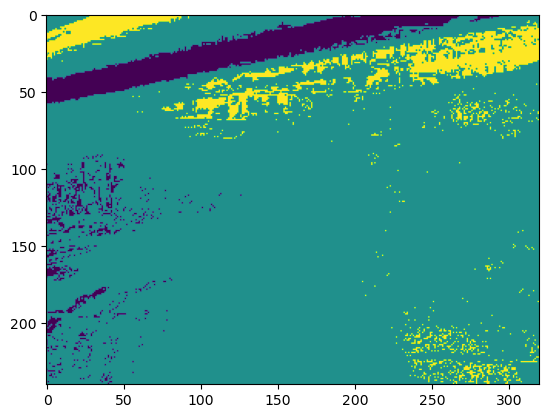

In [547]:
plt.imshow(img[0].detach().cpu().numpy())
plt.show()

In [220]:
out.max()

0.4756005108356476

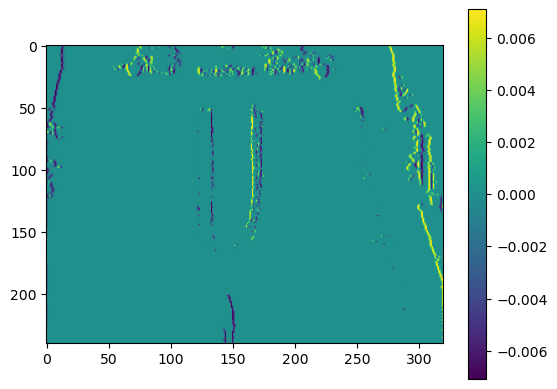

In [545]:
net.eval()

plt.imshow(net.vx.detach().cpu().numpy().squeeze())
plt.colorbar()
plt.show()

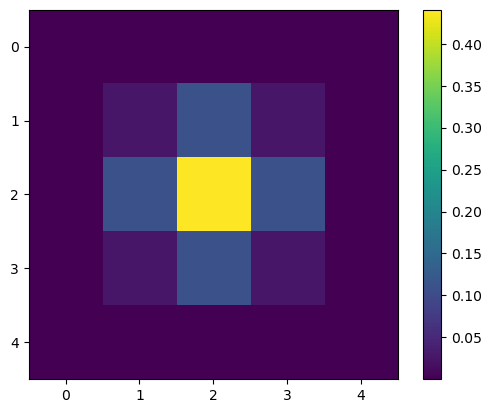

In [470]:
net.eval()
plt.imshow(net.kern_norm.weight.detach().cpu().numpy().squeeze())
plt.colorbar()
plt.show()